#**LSTM**
The problem we are trying to solve here is to classify variable sized sequences of drawings into 10 categories (apple, banana, fork...). 

We are tackling this problem with an LSTM. The input of the LSTM are the keypoints of the drawings in the order in which they were drawn.

The dataset we will use is extracted from the Kaggle competition: **Quick Draw! Doodle Recognition Challenge ** (https://www.kaggle.com/c/quickdraw-doodle-recognition). This dataset contains 

#**1. Notebook Setting**

Import Pytorch and Python libraries (Numpy, Matplotlib...)

In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
  
import numpy as np
import os
import sys
import torch
import torchvision
import random
import codecs
import torch.utils.data
import torch.optim as optim
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
from PIL import Image
from tqdm import tqdm
from torchvision import datasets, transforms

print('Done!')

tcmalloc: large alloc 1073750016 bytes == 0x575c6000 @  0x7f10f75752a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
Done!


In [0]:
!ls 



sample_data


In [0]:
#Training on the GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
!nvidia-smi

cuda:0
Wed Dec 12 17:50:02 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 396.44                 Driver Version: 396.44                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    34W / 149W |     11MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|

# **2. Dataset Preparation**

Download, reduce, reshape and reorganize dataset


## **2.1 Download the Dataset:**

The dataset is downloaded from Google Drive personal account and it comes in the form of a csv files with the sequences.

In [0]:
!pip install googledrivedownloader

In [0]:
  from google_drive_downloader import GoogleDriveDownloader as gdd
  urls = [
        '1JmW1jzvcDCSRg2vr6nBfmnWyR2K665Ny', 
        '1_DRuC1dnG6Rsfb-a32eXD0fh_dpyiuJU',
        '1cBXEmlIAwuOmwPEgd9kbnSvjofGEFIAU',
        '1OZdyx5rXytzXnvTq8S3LZS_Ewl_iyIio',
        '1585P-SU8G_vNGu78yEJhOpH9-ajxz3fm',
        '1a9KvLtNi3crhi3iqBX93UwKlmPlmxnyi',
        '1lnneEBuc2K4papzkui14ZiYN58dMM8VZ',
        '1KdDex8cjZc-SNR8NVURsK-OaXtfxEskU',
        '1fODQI_9LtXyXVk9RNGC7VWZxUlsahxKk',
        '1hbRfukgoLJoQeGtjL820cR89hEqBkzk4'
    ]
  
  class_name = ['apple', 'banana', 'book', 'fork', 'key', 'ladder', 'pizza', 'stop_sign', 'tennis_racquet', 'wheel']

    
  def createDir(path):
    if not os.path.exists(path):
        os.makedirs(path)
  extension = '.csv'
                  
  for i in range(0, len(urls)):
    createDir('data')
    name = class_name[i] + extension
    gdd.download_file_from_google_drive(file_id = urls[i],
                                       dest_path = os.path.join('data', name))
    
    
  print("Done!")   

Done!


## **2.2 Reduction, reshape and reorganization of the Dataset:**

In [0]:
!ls -l data/validation/apple/ | egrep -c '^-'



3001


In [0]:
import pandas as pd
import json

class_name = ['apple', 'banana', 'book', 'fork', 'key', 'ladder', 'pizza', 'stop_sign', 'tennis_racquet', 'wheel']
step = ['train', 'validation', 'test']

dire = r'data/'

max_length = 10000 # Maximum number of files (drawings) per class
percen=[0.6, 0.3, 0.1] # Percentage of training, validation and testing

begin = [0, int(max_length * percen[0]), int(max_length * (percen[0] + percen[1])) + 1]
end = [int(max_length * (percen[0])), int(max_length * (percen[0] + percen[1])) + 1, max_length]

for c in range(0, len(class_name)):
  print('Class ' + str(c+1) + ' out of ' + str(len(class_name)))
  filename = dire + str(class_name[c]) + '.csv'
  
  csv = pd.read_csv(filename, sep = ',')
  drawing = csv[csv['recognized']==True]
  drawings = csv['drawing']
  drawings = drawings.values
  data = drawings
  
  for s in range(0, len(step)):
    dire_step = str(dire) + str(step[s])
    if not os.path.exists(dire_step):
      os.makedirs(dire_step)
    
    for i in range(begin[s], end[s]):
      dire_class = str(dire_step) + '/' + str(class_name[c])
      if not os.path.exists(dire_class):
        os.makedirs(dire_class)
        
       
      x = np.array(json.loads(drawings[i]))
      drawing_strokes = []
      for elem in x:
        mat = np.zeros((2, len(elem[0])))
        mat[0, :] = elem[0][:]
        mat[1, :] = elem[1][:]
        drawing_strokes.append(mat)
      aux = np.zeros((2,1)) 
      for stroke in drawing_strokes:
        aux = np.hstack((aux, stroke))
      sample_name = class_name[c] + '_' + str(step[s]) + '_' + str(i)
      
      np.save(os.path.join(dire_class, sample_name), aux[:, 1:])

print('Done!')

Class 1 out of 10
Class 2 out of 10
Class 3 out of 10
Class 4 out of 10
Class 5 out of 10
Class 6 out of 10
Class 7 out of 10
Class 8 out of 10
Class 9 out of 10
Class 10 out of 10
Done!


## **2.3 Dataset Visualization:**

Visualization of a sequenceto the training set of images of the selected class. 

<class 'numpy.ndarray'>
(4, 2)
[[list([63, 90, 104, 148, 182, 203, 220, 229, 235, 233, 221, 206, 185, 148, 111, 75, 46, 32, 8, 1, 1, 5, 17, 25, 37, 55, 82, 100])
  list([78, 90, 90, 78, 82, 93, 110, 127, 154, 173, 195, 214, 231, 248, 254, 253, 242, 232, 192, 164, 115, 100, 80, 69, 62, 63, 87, 90])]
 [list([94, 90, 86, 97, 113, 113, 104, 100])
  list([86, 43, 30, 29, 36, 49, 68, 92])]
 [list([118, 117, 122, 140, 155, 186, 203, 209, 211])
  list([82, 69, 50, 25, 15, 5, 5, 8, 15])]
 [list([122, 144, 176, 200, 208]) list([76, 76, 57, 27, 0])]]


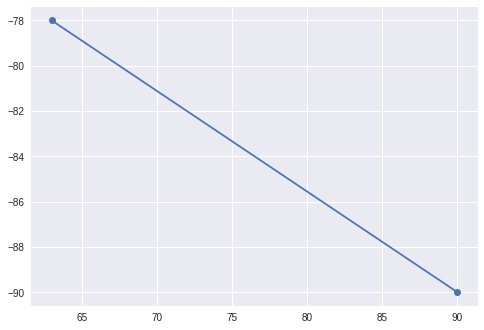

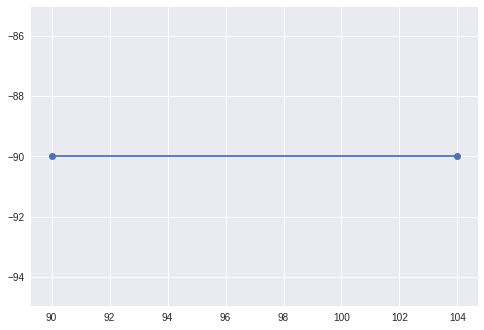

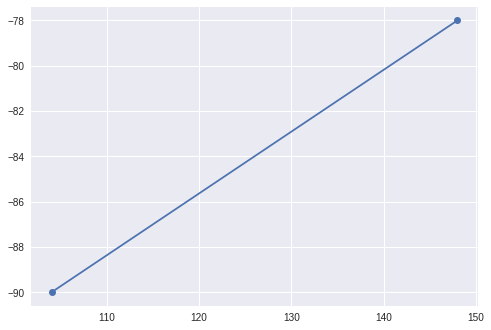

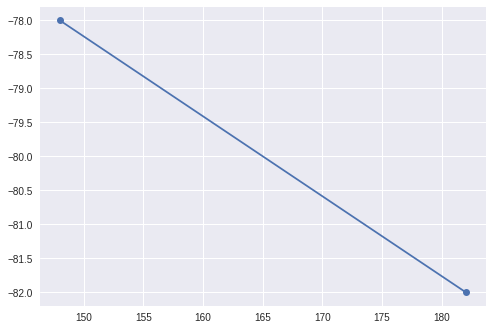

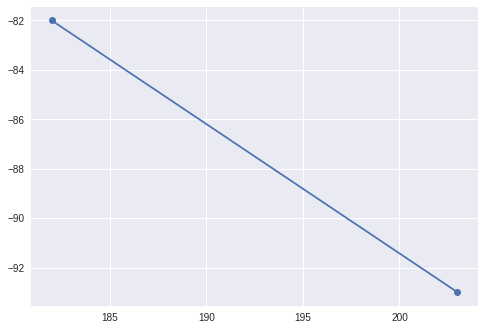

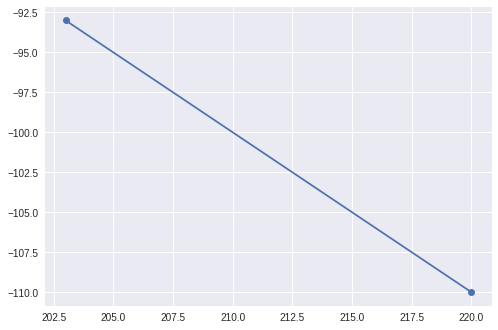

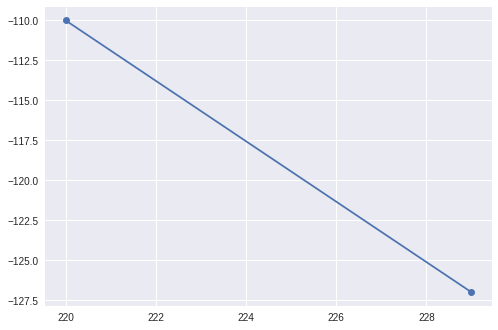

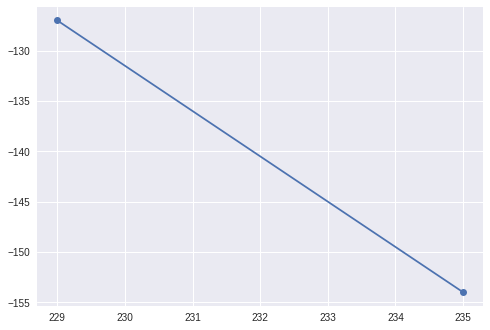

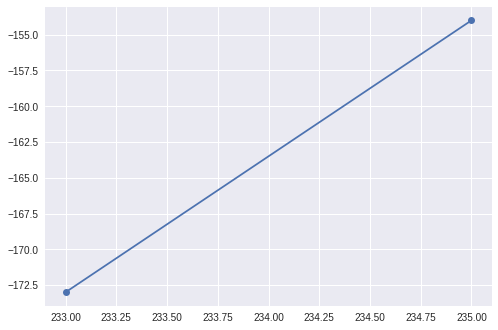

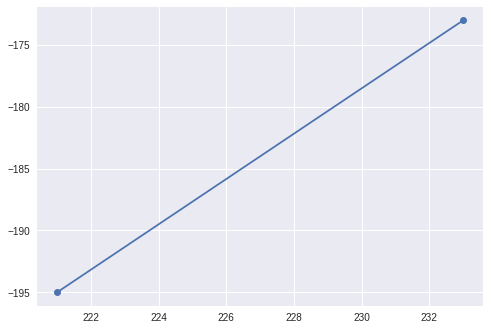

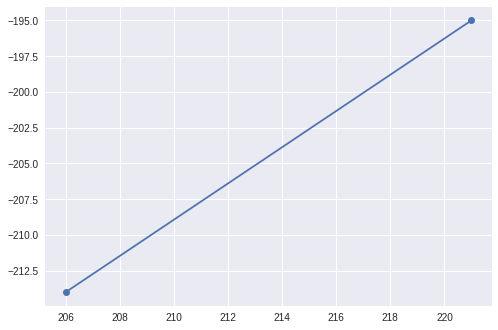

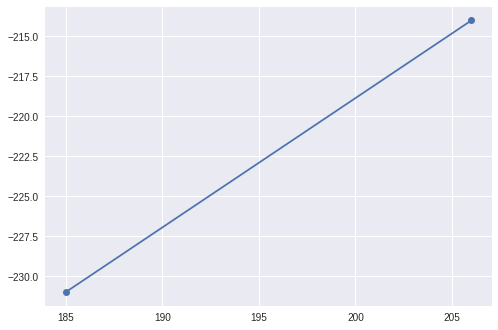

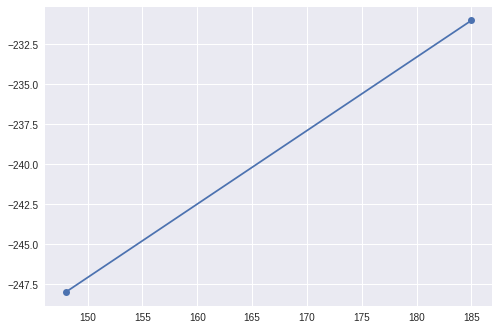

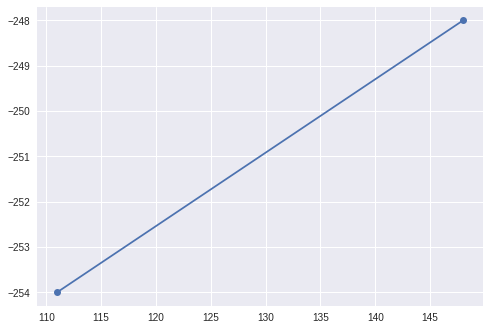

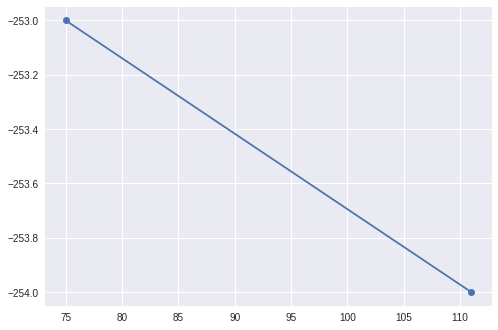

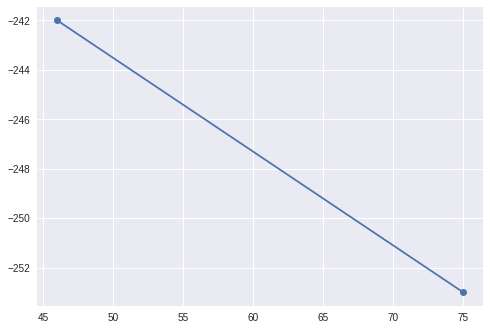

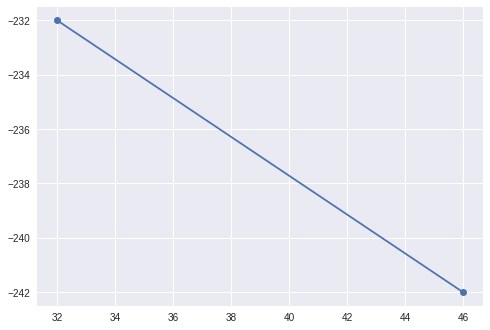

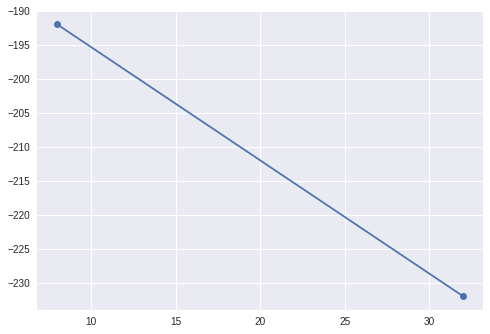

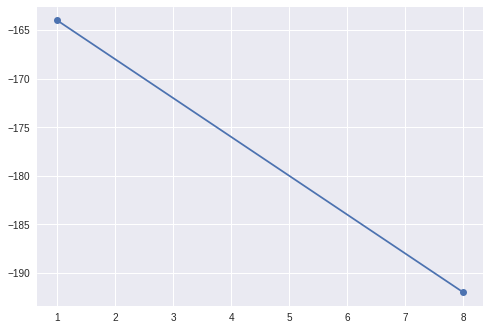

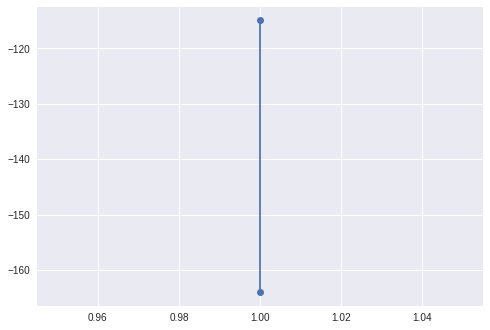

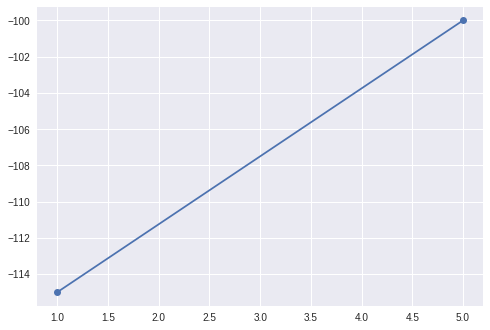

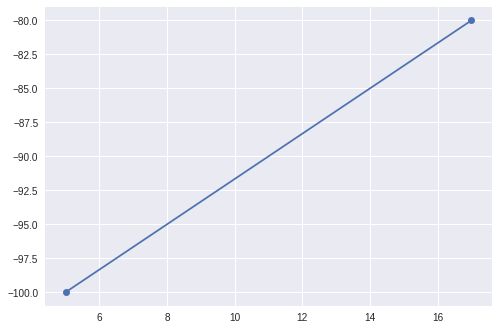

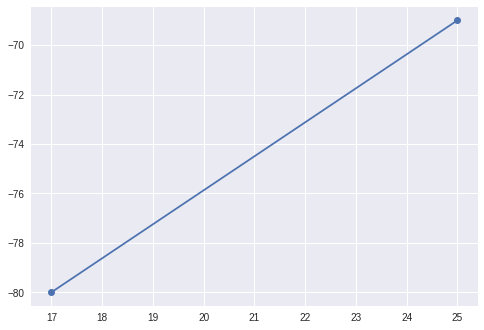

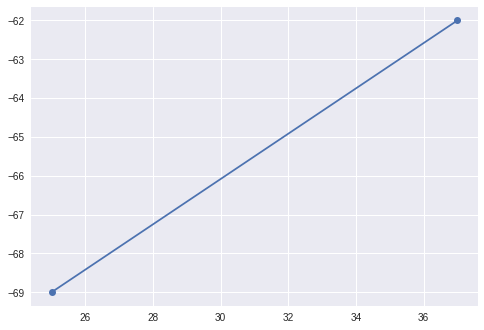

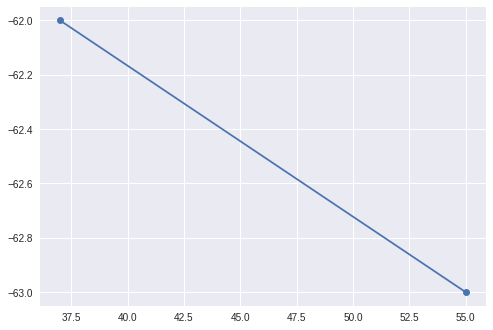

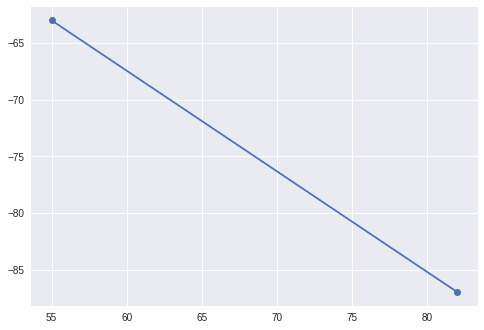

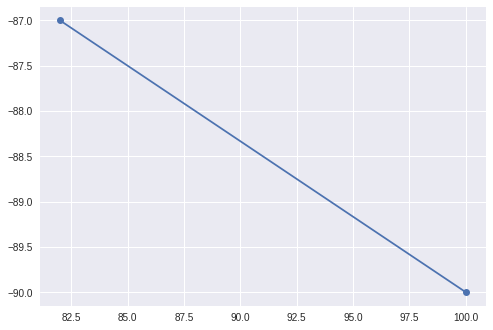

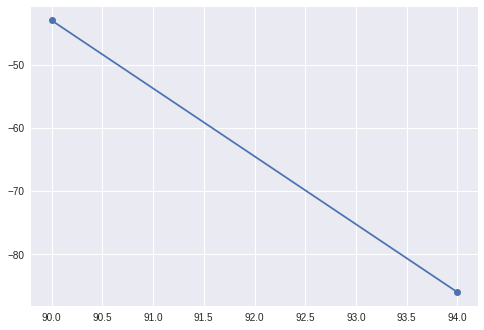

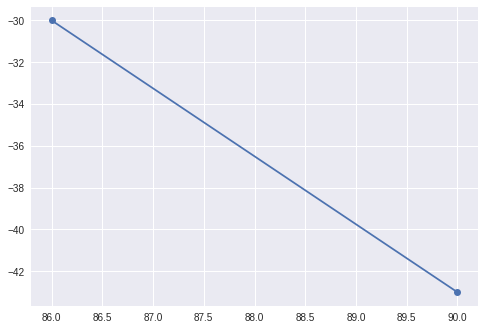

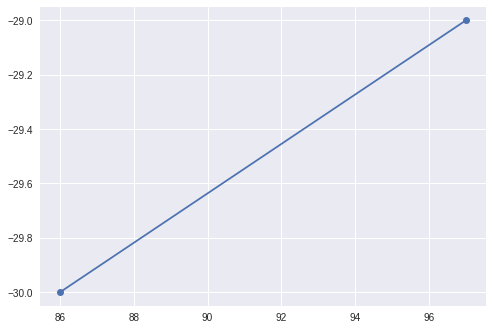

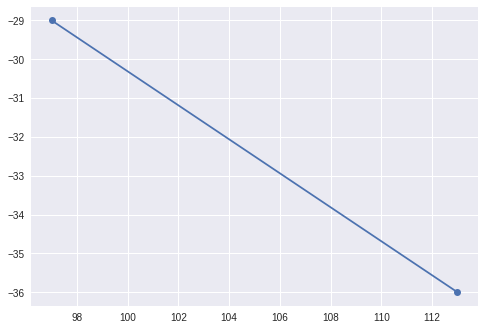

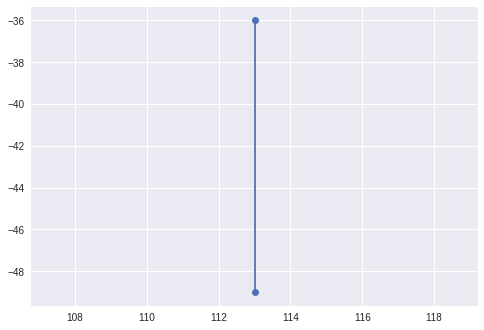

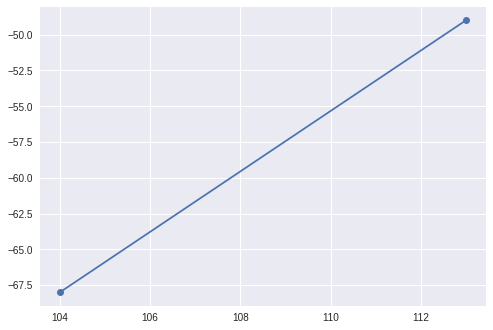

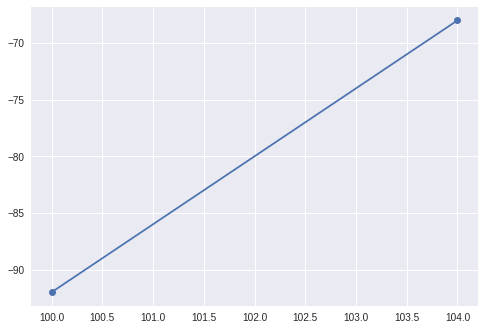

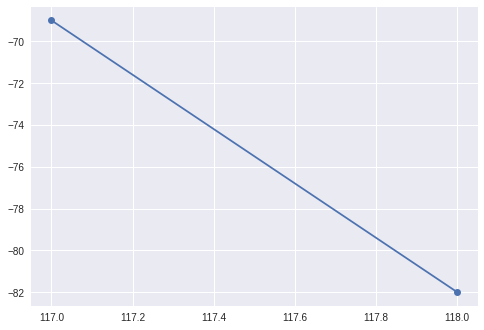

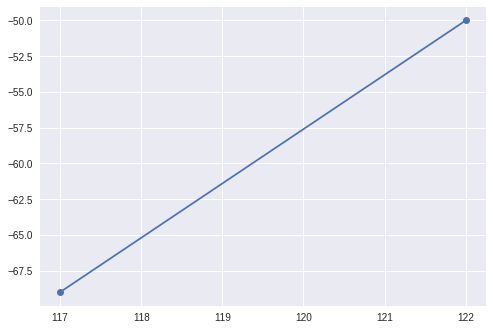

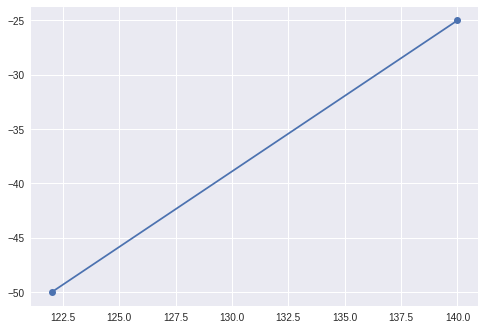

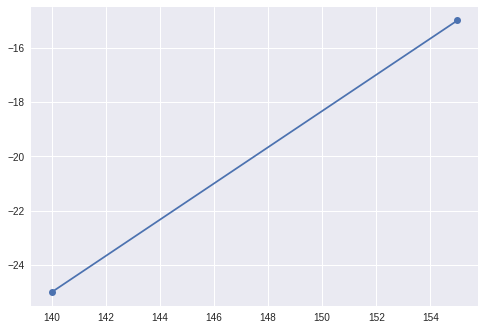

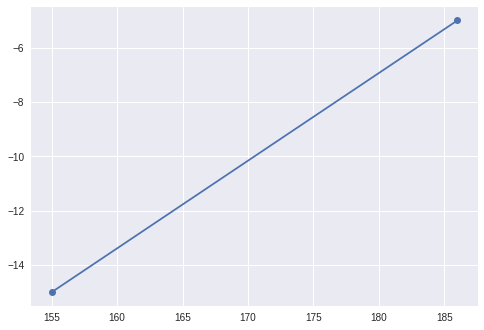

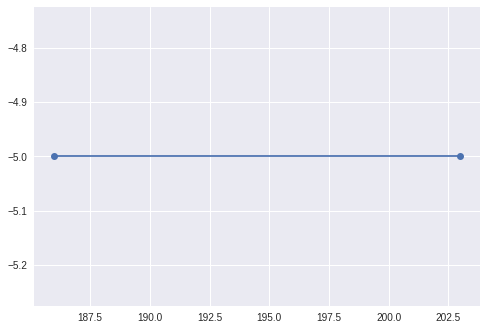

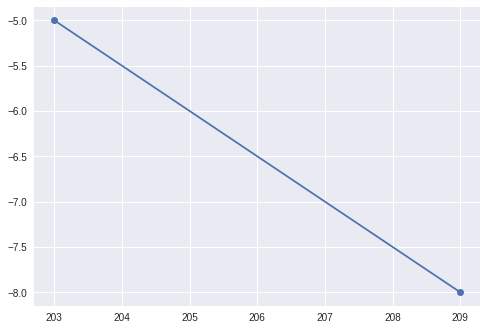

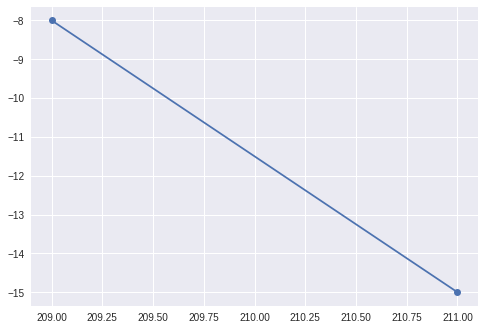

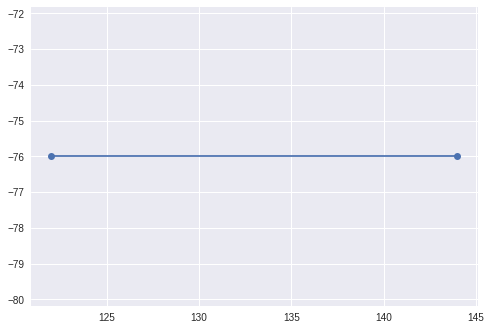

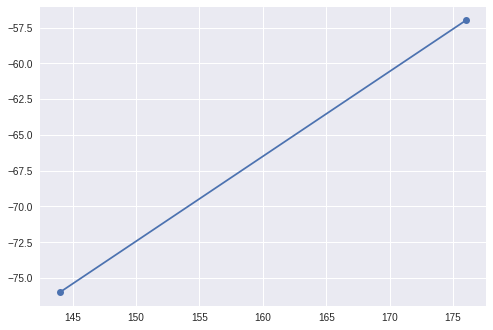

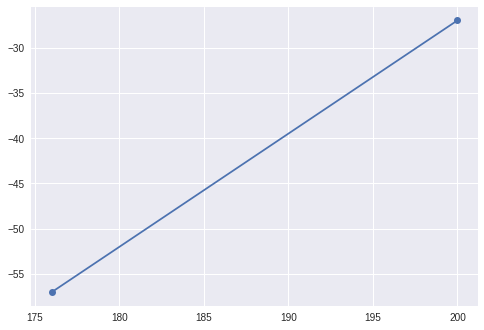

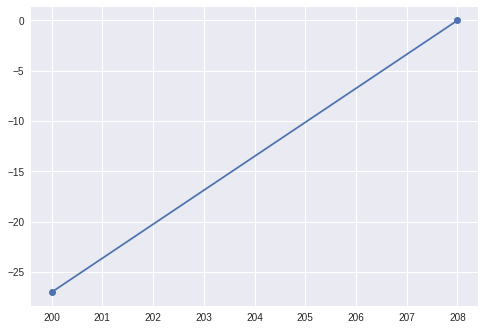

In [0]:
csv = pd.read_csv('data/apple.csv', sep = ',',engine = 'python')

# Header Format
#['countrycode', 'drawing', 'key_id', 'recognized', 'timestamp', 'word'] 
# SELECT ONLY THE ONES CLASSIFIED CORRECTLY
drawing = csv[csv['recognized']==True]
drawings = csv['drawing']
drawings = drawings.values
index = 100000 # This is the good sample to show in presentation
x = np.array(json.loads(drawings[index]))
print(type(x))
print(np.shape(x))
print(x)
img = np.zeros((256, 256))

for elem in x:
	for i in range(0,len(elem[0])-1):
		#plt.subplot(211)
		plt.plot([elem[0][i], elem[0][i+1]], [-elem[1][i], -elem[1][i+1]], marker = 'o')	
		plt.pause(0.05)
	img[elem[1][:], elem[0][:]] = 255

#plt.subplot(212)
#plt.imshow(img)
plt.show()

# **3. Data Loading**

In this section we define the data loaders and the auxiliary classes that make possible loading sequences of different lenghts.

## **3.1  Auxiliriary classes to get variable sized sequences**

This step is crutial for this architecture. EXPLICAR-HO EN SUPER DETALL


In [0]:
def pad_tensor(my_vec, my_pad, my_dim):
    """
    args:
        my_vec - tensor to my_pad
        my_pad - the size to my_pad to
        my_dim - my_dimension to my_pad

    return:
        a new tensor my_padded to 'my_pad' in my_dimension 'my_dim'
    """
    my_pad_size = list(my_vec.shape)
    my_pad_size[my_dim] = my_pad - my_vec.size(my_dim)
    return torch.cat([my_vec, torch.zeros(*my_pad_size).double()], dim=my_dim)

class PadCollate:
	"""
	a variant of callate_fn that pads according to the longest sequence in
	a batch of sequences
	"""
	def __init__(self, dim=0):
		"""
		args:
		dim - the dimension to be padded (dimension of time in sequences)
		"""
		self.dim = dim


	def pad_collate(self, batch):
		"""
		args:
		batch - list of (tensor, label)
		reutrn:
		    xs - a tensor of all examples in 'batch' after padding
		    ys - a LongTensor of all labels in batch
		"""
		# find longest sequence
		lengths = np.flip(np.sort([x[0].shape[self.dim] for x in batch]), axis = 0)
		max_len = max(map(lambda x: x[0].shape[self.dim], batch))
		batch = list(map(lambda x: (pad_tensor(x[0], my_pad=max_len, my_dim=self.dim), x[1]), batch))
		# stack all
		xs = torch.stack(list(map(lambda x: x[0], batch)), dim=1)
		ys = torch.tensor(list(map(lambda x: x[1], batch)))
		return xs, ys, lengths

	def __call__(self, batch):
		return self.pad_collate(batch)


## **3.2 Data Loaders definition**

In [0]:
def load_sample(x):
	# We load them in format N x 2 in order to stack them in proper order
	return torch.from_numpy(np.load(x).T).double()


bs = 30


train_dir = r"data/train"
val_dir = r"data/validation"
test_dir = r"data/test"

train_dataset = datasets.DatasetFolder(train_dir, extensions = ['.npy'], loader = load_sample)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = bs, shuffle = True, num_workers = 0, collate_fn = PadCollate(dim=0))
train_iter = iter(train_loader)

valid_dataset = datasets.DatasetFolder(val_dir, extensions = ['.npy'], loader = load_sample)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size = bs, shuffle = True, num_workers = 0, collate_fn = PadCollate(dim = 0))
valid_iter = iter(valid_loader)

test_dataset = datasets.DatasetFolder(test_dir, extensions = ['.npy'], loader = load_sample)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = bs, shuffle = True, num_workers = 0, collate_fn = PadCollate(dim = 0))
test_iter = iter(test_loader)

#data_iter = torch.utils.data.DataLoaderIter(train_loader)
# El que es printa hauria de ser un batch que entra per fer el forward pass i el seu backward pass corresponent quan entrenem
samples, labels, lengths = valid_iter.next() # Jo crec que va per aqui 
print("El tamany del batch es: ")
print(samples.size())
print("El tamany de les labels es:")
print(labels.size())

El tamany del batch es: 
torch.Size([103, 30, 2])
El tamany de les labels es:
torch.Size([30])


In [0]:
class Quick_draw_LSTM(nn.Module):
  def __init__(self, lstm_input_size, lstm_units, lstm_hidden_units, batch_size, output_dim):
    super(Quick_draw_LSTM, self).__init__()
    self.lstm_input_size = lstm_input_size
    # Number of stacked lstm that we will have 
    self.lstm_units = lstm_units
    self.lstm_hidden_units = lstm_hidden_units
    self.batch_size = batch_size
    self.output_dim = output_dim
    self.__build_model()
  
  def __build_model(self):
    self.lstm = nn.LSTM(input_size = self.lstm_input_size, hidden_size = self.lstm_hidden_units,num_layers = self.lstm_units)
    self.hidden_to_class = nn.Linear(self.lstm_hidden_units, self.output_dim)
    
  def init_hidden(self):
    #hidden_a = torch.randn(self.lstm_units, self.batch_size, self.lstm_hidden_units)
    #hidden_b = torch.randn(self.lstm_units, self.batch_size, self.lstm_hidden_units)
    hidden_a = torch.zeros(self.lstm_units, self.batch_size, self.lstm_hidden_units)
    hidden_b = torch.zeros(self.lstm_units, self.batch_size, self.lstm_hidden_units)
   
    return (hidden_a.to(device), hidden_b.to(device))
  
  def forward(self, X, X_lengths):
    # at the beginning of each sequence we must reset the hidden states
    self.hidden = self.init_hidden()
    seq_len, batch_size, features_size = X.size()
    """We pack the batch with pack_padded_sequence, this method is useful because the LSTM won't see
    the padded values. This function expects as arguments: a tensor of (T x B x *)
    """
    X = nn.utils.rnn.pack_padded_sequence(X, X_lengths)
    X, self.hidden = self.lstm(X, self.hidden)
    X = nn.utils.rnn.pad_packed_sequence(X)
    #print("El tipus de X[0] és: " +str(type(X[0]))) --> torch.Tensor
    
    X = X[0].contiguous()
    X = X.view(-1, X.shape[2])
    X = self.hidden_to_class(X)
    
    #X = F.log_softmax(X, dim=1) #If we use crossEntropy loss it computes the softmax for us!!
    X = X.view(seq_len, batch_size, self.output_dim)
    return X

# **4. Network Training**

In [0]:
#now sample a batch and forward propagate it through the network to see if it works
model = Quick_draw_LSTM(2, 3, 512, bs, 10)
model.to(device)

Quick_draw_LSTM(
  (lstm): LSTM(2, 512, num_layers=3)
  (hidden_to_class): Linear(in_features=512, out_features=10, bias=True)
)

In [0]:
training_loss_list = []
validation_loss_list = []

# Hyper-parameters
epochs = 150
learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

for epoch in range(epochs):
  running_loss = 0.0
  training_accuracy = 0.0
  total = 0.0
  correct = 0.0
  for i, data in enumerate(train_loader, 0):
    model.train()
    # Sample a batch. Recall that we need the lengths for the padding and packing!
    inputs, labels, lengths = data
    #print(type(inputs))
    """inputs = inputs.float()
    labels = labels
    lengths = torch.from_numpy(lengths.copy())
    """
    inputs = inputs.float().to(device)
    labels = labels.to(device)
    lengths = torch.from_numpy(lengths.copy()).to(device)
    #print(lengths)
    # Zero the gradients because pytorch accumulates gradients
    optimizer.zero_grad()
    # Forward + Backward + optimize
    outputs = model(inputs, lengths)
    #print(outputs)
    #print("La size dels outputs es = " + str(outputs.size()))
    #print(lengths)
    # We take only the last output of each sequence! Valid outputs are the outputs computed in the sequence's lengths
    valid_outputs = outputs[np.array(lengths-1), np.arange(0, bs), :]
    #print(valid_outputs.size())
    _, predicted = torch.max(valid_outputs.data, 1)
    #print(predicted)
    total = total + labels.size(0)
    correct = correct + (predicted == labels).sum().item()
    
    #print("La size dels valid outputs es = " + str(valid_outputs.size()))
    #print(valid_outputs)
    loss = criterion(valid_outputs, labels)
    #print(loss)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
    
    
    #print sth
    if i % 200 == 199:
      training_accuracy = correct/total
      print('[%d, %5d] loss: %.3f - Training_Accuracy: %.3f' % (epoch + 1, i + 1, running_loss / 200, training_accuracy))
      training_loss_list.append(running_loss)
      running_loss = 0.0
      training_accuracy = 0.0
      total = 0.0
      correct = 0.0 
      
      with torch.no_grad():
        val_correct = 0.0
        validation_accuracy = 0.0
        val_total = 0.0
        running_validation_loss = 0.0
        model.eval()
        for j, valid_data in enumerate(valid_loader, 0):
          validation_inputs, validation_labels, validation_lengths = valid_data
          #print(validation_lengths)
          validation_inputs = validation_inputs.float().to(device)
          validation_labels = validation_labels.to(device)
          validation_lengths = torch.from_numpy(validation_lengths.copy()).to(device)
          validation_outputs = model(validation_inputs, validation_lengths)

          validation_valid_outputs = validation_outputs[np.array(validation_lengths-1), np.arange(0, bs), :]

          valid_loss = criterion(validation_valid_outputs, validation_labels)
          max_val, val_predicted = torch.max(validation_valid_outputs.data, 1)
          val_total = validation_labels.size(0) + val_total
          val_correct = (val_predicted == validation_labels).sum().item() + val_correct
          running_validation_loss += valid_loss.item()

        validation_accuracy = val_correct / val_total
        print('[%d, %5d] Validation loss: %.3f - Validation_Accuracy: %.3f' %(epoch + 1, i + 1, running_validation_loss/5, validation_accuracy))
        val_correct = 0.0
        validation_accuracy = 0.0
        running_validation_loss = 0.0
          

[1,   200] loss: 0.473 - Training_Accuracy: 0.833


StopIteration: ignored

In [0]:
import numpy as np
import matplotlib.pyplot as plt

training_examples = 6e5
plot_every = 200 #batches
training_loss_np = np.asarray(training_loss_list)
#validation_loss_np = np.asarray(validation_loss_list)

x_axis = np.arange(0, len(training_loss_list))
plt.plot(x_axis * bs * plot_every / training_examples, training_loss_np)
#plt.plot(x_axis * bs * plot_every / training_ex, validation_loss_np)
plt.show()

# **5. Network Testing**

In [0]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

print('GroundTruth: ', ' '.join('%5s' % class_name[labels[j]] for j in range(4)))
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_name[predicted[j]] for j in range(4)))

Let's evaluate the model on the test data:

While our densely-connected network we had a test accuracy of 97.8%, our basic convnet has a test accuracy of 99.3%: we decreased our error rate by 68% (relative).

In [0]:
# ACCURACY OF THE NETWORK
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

In [0]:
#WHICH CLASSESS PERFORMED BETTER
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

**Coses que falten:**


1.   Passar-ho a la GPU (*en teoria ja està però repassar*)
2.   Revisar hiperparametres/tamany xarxa/arquitectura per millorar el train
3.   Afegir validation
4.   Afegir test
5.   Afegir plots de les losses, accuracy
6.   Redactar tots els apartats



